TP2 Implémenter Word2vec
========================

## Table of Contents

- [Récupérer les données](#Rcuprer-les-donnes)
- [Nettoyage et conversion](#Nettoyage-et-conversion)
- [Jeu de données](#Jeu-de-donnes)
- [Évaluation](#valuation)
- [La boucle d&rsquo;apprentissage](#La-boucle-dapprentissage)
- [Création et en entraînement](#Cration-et-en-entranement)



# Table des matières



Dans ce TP, sur deux parties, nous implémenterons deux versions de word2vec.

1.  La première vise à maximiser la vraisemblance des contextes
    obeservés. On utilisera une distribibution exponentielle (distribution de
    Gibbs/softmax) où les potentiels sont donnés par la similarité entre mot
    central et mot contextuel calculée par produit scalaire.
2.  La deuxième est la version dérivée par Mikolov et al. pour éviter de calculer
    un softmax sur le lexique. Elle repose sur une fonction de perte alternative,
    l&rsquo;échantillonnage de contre-exemples, et la rectification par softplus.

On verra aussi le comportement des différentes versions sur deux jeux de données
différents. Le premier est un corpus relativement petit de critiques de films
tandis que le second est un corpus plus grand d&rsquo;articles de presse.



## Récupérer les données



Le code suivant télécharge les données. La partie commentée récupère le second corpus, inutile dans un premier temps pour développer votre prototype.



In [1]:
!wget http://mattmahoney.net/dc/text8.zip
!unzip text8
!ls

--2025-12-31 08:17:45--  http://mattmahoney.net/dc/text8.zip
Résolution de mattmahoney.net (mattmahoney.net)… 20.119.76.151
Connexion à mattmahoney.net (mattmahoney.net)|20.119.76.151|:80… connecté.
requête HTTP transmise, en attente de la réponse… 200 OK
Taille : 31344016 (30M) [application/zip]
Sauvegarde en : « text8.zip »

text8.zip           100%[===================>]  29,89M  5,29MB/s    ds 6,3s    

2025-12-31 08:17:51 (4,74 MB/s) — « text8.zip » sauvegardé [31344016/31344016]

Archive:  text8.zip
  inflating: text8                   
Student_TP_diffusion.ipynb    Student_TP_Word2vec_mle.ipynb
Student_TP_LM.ipynb	      Student_TP_Word2vec.ipynb
Student_TP_RLHF.ipynb	      text8
Student_TP_Transformer.ipynb  text8.zip
Student_TP_Word2vec_cd.ipynb


On affiche quelques lignes du corpus:



In [2]:
!wc text8
!head -c 200 text8

        0  17005207 100000000 text8
 anarchism originated as a term of abuse first used against early working class radicals including the diggers of the english revolution and the sans culottes of the french revolution whilst the term 

## Nettoyage et conversion



La fonction suivante réalise les différentes tâches suivantes:

1.  création d&rsquo;une table wordcount qui associe à chaque mot son nombre d&rsquo;occurrences
2.  fixe une limite à la taille du vocabulaire, les mots les moins fréquents sont éliminés
3.  création d&rsquo;une table word2idx  des mots vers des identifiants entiers uniques
4.  création d&rsquo;une table idx2word symétrique
5.  Finalement crée le corpus d&rsquo;exemples sous la forme d&rsquo;un tableau d&rsquo;indices



In [3]:
import torch

#device = torch.device("mps")
device = torch.device("cuda:0")
#device = torch.device("cpu")
       

In [4]:
import random
import math
import gc

            
def corpus2train(path, voc_max_size=16384):

  wordcount = {}
  lines = []

  print("counting words")
  f = open(path, 'r')
  for line in f:
    #les mots de la phrase
    tokens = line.lower().split()
    # on met à jour les comptes
    for t in tokens:
      if t in wordcount:
        wordcount[t] +=1
      else:
        wordcount[t] = 1
    lines.append(tokens)
  f.close()


  print("remove rare words")
  # your code here
  ### BEGIN SOLUTION
  wc_st = sorted(wordcount.items(), key=lambda x : -x[1])
  wc_st = wc_st[:voc_max_size]
  ### END SOLUTION

  print("building tables")
  # your code here
  ### BEGIN SOLUTION
  ### END SOLUTION

  print("put all data in a single array")
  corpus = sum(lines, [])
  train = torch.zeros(len(corpus))
  for i in range(len(corpus)):
    train[i] = word2idx[corpus[i]] if corpus[i] in word2idx else voc_max_size
  
  train = train[train < voc_max_size].to(dtype=torch.uint16, device=device)

  return(train, word2idx, idx2word, counts)

In [5]:
trainset,word2idx,idx2word,wordcount = corpus2train("text8")

print ("number of examples in training set:", len(trainset))
print("number of words:", len(wordcount))

counting words
remove rare words
building tables
put all data in a single array
number of examples in training set: 15823662
number of words: 16384


## Jeu de données



Un jeu de données est un objet d&rsquo;une sous-classe de `torch.utils.data.Dataset`, qui implémente deux méthodes `__len__` qui renvoie le nombre d&rsquo;exemples du jeu de données,
et `__getitem__` qui étant donné un entier *i* revoie la i<sup>e</sup> donnée du jeu.
On peut stocker des informations supplémentaires dans l&rsquo;objet. C&rsquo;est ce qu&rsquo;on fait ici.



In [6]:
#USE PYTORCH API for DATASETS
import torch

class W2VDataset(torch.utils.data.Dataset):
  def __init__(self, file, window_size=16,voc_max_size=16384):
      self.data, self.word2idx, self.idx2word, self.wordcount = corpus2train(file,voc_max_size)
      self.window_size = window_size
      self.data = self.data.to(device=device)
 
  def __len__(self):
    return len(self.data)

  def __getitem__(self, idx):
    return self.data[idx]

dataset= W2VDataset("text8", window_size=16, voc_max_size=65536-1)

counting words
remove rare words
building tables
put all data in a single array


In [7]:
print (len(dataset.data))
print(len(dataset.wordcount))

print(dataset.wordcount[word2idx["man"]])
visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet",
    #"enjoyable",
    "boring", "bad", "dumb",
    #"annoying",
    "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]
for w in visualizeWords:
  print(w, dataset.wordcount[word2idx[w]])

16690069
65535
5778
great 7770
cool 358
brilliant 205
wonderful 174
well 11537
amazing 181
worth 528
sweet 372
boring 63
bad 974
dumb 68
female 2797
male 2615
queen 1940
king 7456
man 5778
woman 1753
rain 513
snow 582
hail 70
coffee 489
tea 388


## Évaluation



on évaluera informellement le modèle appris, en affichant les vecteurs appris par les modèles sur quelques mots choisis.

L&rsquo;évaluation projette les vecteurs sur deux dimensions (en essayant de minimiser la distance entre la matrice d&rsquo;origine et la matrice projetée &ldquo;déprojetée&rdquo;, cf algorithme de la décomposition en valeur singulière), et crée le graphique sur le carnet.

Attention sur evaluate est appelée plusieurs fois dans la même cellule, les graphiques se superposent.

Attention, evaluate suppose que l&rsquo;implémentation à évaluer a deux variables de type torch.nn.Embedding, l&rsquo;une nommée V qui contient les vecteurs des mots centraux, l&rsquo;autre nommée U qui contient les vecteurs des mots contexte.

N&rsquo;oubliez pas d&rsquo;implémenter la fin de la fonction !



In [8]:
import numpy as np
import matplotlib
matplotlib.use('agg')
import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.manifold import TSNE
import pandas as pd


def evaluate(module, word2idx, idx2word, vistype=None):
    #finalisation des vecteurs de mots
    word_vectors = module.V.weight
    #print(word_vectors.size())
    word_vectors = word_vectors.detach().cpu()
    wv = word_vectors.numpy()

    #on teste sur ce sous-ensemble de mots (synonymes/antonymes...)
    visualizeWords = [
    "great", "cool", "brilliant", "wonderful", "well", "amazing",
    "worth", "sweet", "enjoyable", "boring", "bad", "dumb",
    "annoying", "female", "male", "queen", "king", "man", "woman", "rain", "snow",
    "hail", "coffee", "tea"]
    visualizeWords = [w for w in visualizeWords if w in word2idx]

    visualizeIdx = [word2idx[word] for word in visualizeWords]
    #print(visualizeIdx)
    visualizeVecs = wv[visualizeIdx, :]

    if vistype == 'tSNE':
      tsne = TSNE(n_components=2)
      X_tsne = tsne.fit_transform(wv)[visualizeIdx,:]
      df = pd.DataFrame(X_tsne, index=visualizeWords, columns=['x', 'y'])

      fig = plt.figure()
      ax = fig.add_subplot(1, 1, 1)

      ax.scatter(df['x'], df['y'])

      for word, pos in df.iterrows():
        ax.annotate(word, pos)

      plt.show()

    else:
      # réduction de dimension des vecteurs (en 2D pour visualisation)
      temp = (visualizeVecs - np.mean(visualizeVecs, axis=0))
      covariance = 1.0 / len(visualizeIdx) * temp.T.dot(temp)
      U,S,V = np.linalg.svd(covariance)
      #print(U.shape, S.shape, V.shape)
      coord = temp.dot(U[:,0:2])

      for i in range(len(visualizeWords)):
        plt.text(coord[i,0], coord[i,1], visualizeWords[i],
            bbox=dict(facecolor='green', alpha=0.1))

      plt.xlim((np.min(coord[:,0]), np.max(coord[:,0])))
      plt.ylim((np.min(coord[:,1]), np.max(coord[:,1])))

    #plt.savefig('word_vectors.png')


    #TODO:
    #Afficher les dix mots les plus similaires à "man"
    # en utilisant la "similarité cosinus"
    #https://pytorch.org/docs/stable/generated/torch.nn.CosineSimilarity.html

    # your code here
    ### BEGIN SOLUTION
    ### END SOLUTION

## La boucle d&rsquo;apprentissage



In [9]:
#module : votre implémentation de w2v
#opt: l'optimisateur de descente de gradient
#dataset: tableau qui contient toutes les données
#nb_epoch, le nombre de parcours de train_set

def train(module, opt, sched, loss_module, dataset, nb_epoch, batch_size):

  dataloader = torch.utils.data.DataLoader(dataset, batch_size, shuffle=True)
  ignore_index = -100
  max_index = len(dataset.wordcount)

  unigrams = torch.tensor(dataset.wordcount,dtype=torch.float32, device=module.device)
  total = unigrams.sum()
  unigrams = unigrams / total
    
  accept = torch.ones_like(unigrams)

  accept =  1e-3 / unigrams
  accept = torch.clip(accept + torch.sqrt(accept), 0.0, 1.0)
  accept /= accept.mean()


  #print(dataset.data.device)
    
  for epoch in range(nb_epoch):
    epoch_loss = 0

    for batch_center in dataloader:
      # your code here
      ### BEGIN SOLUTION
      ### END SOLUTION

    print(f"epoch: {epoch}\tloss: {epoch_loss/len(dataloader)}")
    sched.step(epoch_loss)
    print(sched.get_last_lr())

  evaluate(module, dataset.word2idx, dataset.idx2word)

In [10]:
class Word2Vec(torch.nn.Module):
  def __init__(self, lexicon_size, vec_size, device):
    super().__init__()
    self.V = torch.nn.Embedding(lexicon_size, vec_size, max_norm=None)
    self.U = torch.nn.Embedding(lexicon_size, vec_size, max_norm=None)

    self.vec_size =vec_size
    self.device=device
    self.init_emb()
    self = self.to(device)

  # initialisation des embeddings comme Mikolov et al.
  def init_emb(self):
    self.V.weight.data.normal_(std= 0.5 / math.sqrt(self.vec_size))
    self.U.weight.data.normal_(std= 0.5 / math.sqrt(self.vec_size))

    
  # calcule les scores <w_o, w_c> pour tout w_o
  def forward(self,idx_c):
    # your code here
    ### BEGIN SOLUTION
    ### END SOLUTION
      
    return torch.einsum('bi,li->bl',v,u)

man tensor(1.0000)
wiped tensor(0.5175)
grandma tensor(0.5085)
denver tensor(0.4921)
lycaon tensor(0.4826)
penalties tensor(0.4823)
simulators tensor(0.4803)
iga tensor(0.4786)
fallible tensor(0.4737)
blanca tensor(0.4708)


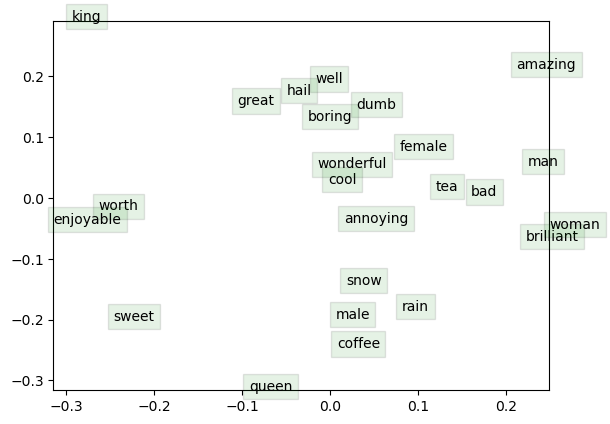

In [11]:
VECTOR_SIZE=50

w2v = Word2Vec(len(dataset.idx2word), VECTOR_SIZE, device)


#on regarde les vecteurs après initialisation aléatoire
evaluate(w2v, dataset.word2idx, dataset.idx2word)

In [12]:
class MLELoss(torch.nn.Module):
  def __init__(self):
    super().__init__()

    # pour créer la distribution d'échantillonnage
    self.ls = torch.nn.CrossEntropyLoss(reduction='none')

  #calcule scores
  def forward(self, net, input, target, weight):
    losses = self.ls(net(input.to(dtype=torch.int32)), target.to(dtype=torch.int32))
    return (weight * losses).mean()

## Création et en entraînement



epoch: 0	loss: 11.086019472019402
[0.0001]
man tensor(1.0000)
wiped tensor(0.5444)
grandma tensor(0.5201)
denver tensor(0.5136)
penalties tensor(0.5055)
blanca tensor(0.4940)
lycaon tensor(0.4918)
existential tensor(0.4841)
another tensor(0.4833)
paganini tensor(0.4830)


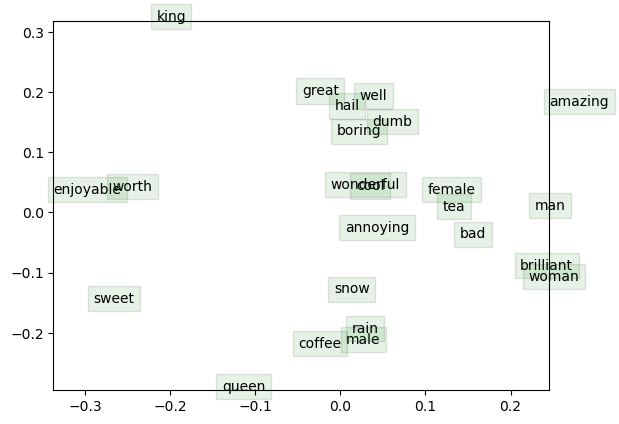

In [13]:
BATCH_SIZE = 10000

optimizer = torch.optim.RAdam(w2v.parameters(), lr=1e-4, decoupled_weight_decay=True, weight_decay=1e-5)
#optimizer = torch.optim.SGD(w2v.parameters(), lr=1e-2, weight_decay=1e-5, momentum=0.0)
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=100, factor=0.5)

loss_module = MLELoss()
train(w2v, optimizer, scheduler, loss_module, dataset, 1, BATCH_SIZE)

In [ ]:
# measure time
%timeit train(w2v, optimizer, scheduler, loss_module, dataset, 1, BATCH_SIZE)

epoch: 0	loss: 11.072739397837017
[0.0001]
man tensor(1.0000)
here tensor(0.5970)
another tensor(0.5955)
war tensor(0.5763)
j tensor(0.5698)
wiped tensor(0.5551)
fact tensor(0.5546)
denver tensor(0.5488)
and tensor(0.5465)
b tensor(0.5428)


In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 1, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 10, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 20, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 50, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 100, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 500, BATCH_SIZE)

In [ ]:
train(w2v, optimizer, scheduler, loss_module, dataset, 1000, BATCH_SIZE)